# Part 0: Dataloader and Visualizations

In [1]:
import torch
import wandb
import scipy.io

import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from voc_dataset import VOCDataset

from PIL import Image

from utils import *

USE_WANDB = True

## Editing the Dataloader
The first part of the assignment involves editing the dataloader so that we can access bounding-box proposals as well as the ground-truth bounding boxes. The ground truth bounding box can be accessed through the VOC Dataset annotations itself. Unsupervised bounding box proposals are obtained through methods such as [Selective Search](https://ivi.fnwi.uva.nl/isis/publications/2013/UijlingsIJCV2013/UijlingsIJCV2013.pdf).

Since Selective Search is slow to run on each image, we have pre-computed the bounding box proposals. You should be able to access the `.mat` files using `scipy.io.loadmat('file.mat')`. Feel free to experiment with the data in the files to figure out the number of proposals per image, their scores, etc.

Your task is to change the dataloader to obtain the ground-truth bounding boxes, as well as the proposed bounding boxes for each image. Returning a dictionary would be convenient here. For the bounding boxes, using the relative positions is usually a better idea since they are invariant to changes in the size of the image.

In [2]:
# Load the Dataset - items at a particular index can be accesed by usual indexing notation (dataset[idx])
dataset = VOCDataset('trainval', top_n=10)

In [3]:
split = 'trainval'
selective_search_dir = os.path.join("../data/VOCdevkit/VOC2007/", 'selective_search_data')
roi_data = scipy.io.loadmat(selective_search_dir + '/voc_2007_'+ split + '.mat')
print(roi_data.keys())
# print(roi_data.values())
# print(roi_data['boxScores'].shape)
# print(roi_data['boxes'].shape)
# print(roi_data['images'].shape)
# print(roi_data['images'][:,0].shape)

img = 2020
# print(roi_data['images'][:,img])
# print(roi_data['images'][:,1])
# print(roi_data['boxes'][:,img][0].shape)
# print(roi_data['boxes'][:,img][0])
# print(roi_data['boxScores'][0,img].shape)
# print(roi_data['boxScores'][:,img][0])
box_scores = roi_data['boxScores'][0,img]
boxes = roi_data['boxes'][:,img][0]
print("Box scores: ", len(box_scores), type(box_scores), box_scores.shape)
# print(box_scores)

ind = np.argpartition(box_scores, -4, axis=0)[-4:]
# print(ind)
# print(box_scores[ind])

# print(boxes[ind])
# print(boxes[ind[0]])
top_n = 4
print(boxes[:top_n])
print(boxes[:top_n][0])
print(boxes[:top_n].shape)
height = 350
width = 500

box = boxes[:top_n]

print(box.shape)
# box = boxes[ind][:,0,:]
y1 = box[:,0]
y2 = box[:,2]
x1 = box[:,1]
x2 = box[:,3]
proposals = np.empty((4,1))
proposals = np.concatenate((proposals, np.divide(y1,height).reshape(4,1)), axis=1)
proposals = np.concatenate((proposals, np.divide(x1,width).reshape(4,1)), axis=1)
proposals = np.concatenate((proposals, np.divide(y2,height).reshape(4,1)), axis=1)
proposals = np.concatenate((proposals, np.divide(x2,width).reshape(4,1)), axis=1)
proposals = proposals[:, 1:]
print(box)
print(proposals)
# print(type(box[0]))
# print(box.shape)
# yy = box[:,1]/500
# box[:,1] = yy
# # print(box.shape)
# print(box)

proposal = []
for i in range(len(box)):
    xmin = int(box[i,0]) / height
    ymin = int(box[i,1])  / width
    xmax = int(box[i,2])  / height
    ymax = int(box[i,3])  / width
    proposal.append([xmin, ymin, xmax, ymax])

print(np.array(proposal))

dict_keys(['__header__', '__version__', '__globals__', 'boxScores', 'boxes', 'images'])
Box scores:  1270 <class 'numpy.ndarray'> (1270, 1)
[[  1 187 220 479]
 [191 187 293 381]
 [  1  86 216 481]
 [191 186 256 381]]
[  1 187 220 479]
(4, 4)
(4, 4)
[[  1 187 220 479]
 [191 187 293 381]
 [  1  86 216 481]
 [191 186 256 381]]
[[0.00285714 0.374      0.62857143 0.958     ]
 [0.54571429 0.374      0.83714286 0.762     ]
 [0.00285714 0.172      0.61714286 0.962     ]
 [0.54571429 0.372      0.73142857 0.762     ]]
[[0.00285714 0.374      0.62857143 0.958     ]
 [0.54571429 0.374      0.83714286 0.762     ]
 [0.00285714 0.172      0.61714286 0.962     ]
 [0.54571429 0.372      0.73142857 0.762     ]]


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x373 at 0x7FA9FEBC5F10>
[191 187 293 381]
(187, 191) 102 194


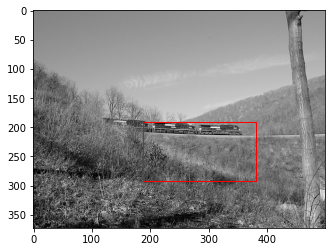

In [4]:
img_path = os.path.join("../data/VOCdevkit/VOC2007/JPEGImages/004005.jpg")
image = Image.open(img_path)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()
print(image)
# Display the image
ax.imshow(image)
box = boxes[ind[2]][0]
print(box)
xy = (box[1], box[0])
h = box[2]-box[0]
w = box[3] - box[1]
print(xy, h, w)
# Create a Rectangle patch
rect = patches.Rectangle(xy, w, h,  linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)


plt.imshow(image)
plt.show()

In [5]:
#TODO: get the image information from index 2020
idx = 2020

input = dataset[idx]

# print(input.)

## Wandb Init and Logging
Initialize a Weights and Biases project, and convert the image tensor to a PIL image and plot it (check `utils.py` for helper functions).

You can use [this](https://docs.wandb.ai/library/log) as a reference for logging syntax.

In [6]:
if USE_WANDB:
    wandb.init(project="vlr2", reinit=True)

wandb: Currently logged in as: unanditha02 (use `wandb login --relogin` to force relogin)


See this block as an example of plotting the ground truth box for an image.

In [7]:
class_id_to_label = dict(enumerate(dataset.CLASS_NAMES))

original_image = tensor_to_PIL(input['image'])
gt_labels = input['gt_classes']
gt_boxes = input['gt_boxes']
print(gt_labels,gt_boxes)

img = wandb.Image(original_image, boxes={
    "predictions": {
        "box_data": get_box_data(gt_labels, gt_boxes),
        "class_labels": class_id_to_label,
    },
})
wandb.log({"image": img})

KeyError: 'gt_classes'

Check the `get_box_data` function in `utils.py` and understand how it is being used. Log the image with the GT bounding box on wandb.
After, this you should be able to easily plot the top 10 bounding proposals as well.

In [8]:
rois = input['rois']
# nums = range(len(rois)) # placeholder for names of proposals
nums = input['label']
print(rois,nums)

original_image = tensor_to_PIL(input['image'])

#TODO: plot top ten proposals (of bounding boxes)
img = wandb.Image(original_image, boxes={
    "predictions": {
        "box_data": get_box_data(nums, rois),
        "class_labels": class_id_to_label,
    },
})
wandb.log({"image proposals": img})

[[0.00268097 0.374      0.58981233 0.958     ]
 [0.51206434 0.374      0.78552279 0.762     ]
 [0.00268097 0.172      0.57908847 0.962     ]
 [0.51206434 0.372      0.68632708 0.762     ]
 [0.00268097 0.514      0.51474531 0.958     ]
 [0.47453083 0.372      0.89008043 0.726     ]
 [0.31099196 0.254      0.58176944 0.726     ]
 [0.48525469 0.378      0.86058981 0.8       ]
 [0.00268097 0.862      0.46380697 1.        ]
 [0.49865952 0.286      0.82841823 0.764     ]] tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.])


IndexError: index 10 is out of bounds for axis 0 with size 10

In [6]:
# roi_data = scipy.io.loadmat(selective_search_dir + '/voc_2007_'+ split + '.mat')
# data_dir='../data/VOCdevkit/VOC2007/'
# img_dir = os.path.join(data_dir, 'JPEGImages')
# index=2020
# '004003'
# findex = '004005'    # findex refers to the file number
# fpath = os.path.join(img_dir, findex + '.jpg')

# img = Image.open(fpath)
# width, height = img.size

# plt.imshow(img)
# plt.show()

# score = roi_data['boxScores'][0,index]
# boxes = roi_data['boxes'][0,index]
# images = roi_data['images'][0,index]
# print(boxes.shape, score.shape)
# print(roi_data.keys())
# print(images)
# print(roi_data.keys())
idx= 2020
image = dataset[idx]
print(image.keys())

print(image["label"].shape, image["label"])
print(image["wgt"].shape, image["wgt"])
print(image["rois"].shape, image["rois"])
print(len(image["gt_boxes"]), image["gt_boxes"])
print(len(image["gt_classes"]), image["gt_classes"])



dict_keys(['image', 'label', 'wgt', 'rois'])
torch.Size([20]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.])
torch.Size([20]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
(10, 4) [[0.00268097 0.374      0.58981233 0.958     ]
 [0.51206434 0.374      0.78552279 0.762     ]
 [0.00268097 0.172      0.57908847 0.962     ]
 [0.51206434 0.372      0.68632708 0.762     ]
 [0.00268097 0.514      0.51474531 0.958     ]
 [0.47453083 0.372      0.89008043 0.726     ]
 [0.31099196 0.254      0.58176944 0.726     ]
 [0.48525469 0.378      0.86058981 0.8       ]
 [0.00268097 0.862      0.46380697 1.        ]
 [0.49865952 0.286      0.82841823 0.764     ]]


KeyError: 'gt_boxes'

In [9]:
inp_size = 32
train_sampler = None
workers = 4
batch_size = 32
train_dataset = VOCDataset('trainval', image_size=inp_size, top_n=10)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        # shuffle=(train_sampler is None),
        shuffle=False,
        num_workers=workers,
        pin_memory=True,
        sampler=train_sampler,
        drop_last=True)

for i, (data) in enumerate(train_loader):
    img = data['image'].to('cuda')
    target = data['label'].to('cuda')
    wgt = data['wgt']

    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
